In [74]:
%load_ext autoreload

%autoreload 2

import cPickle as pickle
from glob import glob
import subprocess
import sys
import string
import os
import random
import numpy as np
from os.path import join
import matplotlib.pyplot as plt
%matplotlib inline

import threebody

import logging
logger = logging.getLogger()
#logger.setLevel(logging.DEBUG)
logger.setLevel(logging.INFO)
logging.debug("test")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [75]:
qsub_script = string.Template("""#!/bin/sh
#PBS -lnodes=1:ppn=1:compute:old
#PBS -N threebody_derivative_$name
#PBS -V
#PBS -o $DIR/pbs-$p.out
#PBS -e $DIR/pbs-$p.err

cd $here
export PATH=/users/aarchiba/.virtualenvs/triplesystem/bin:/users/aarchiba/.local/bin:/usr/local/src/presto/bin:/users/aarchiba/bin:/usr/local/src/fv5.4:/usr/local/openmpi-2.1.0/bin/:/users/aarchiba/.local/bin:/opt/rh/python27/root/usr/bin:/opt/rh/rh-git29/root/usr/bin:/opt/rh/devtoolset-6/root/usr/bin:/usr/local/src/presto/bin:/users/aarchiba/bin:/usr/local/src/fv5.4:/usr/local/openmpi-2.1.0/bin/:.:/users/aarchiba/bin:/opt/local/share/cv/bin:/usr/local/bin:/opt/local/bin:/bin:/usr/bin:/bin:/usr/etc:/usr/sbin:/sbin:/usr/local/sbin:/users/aarchiba/.local/bin:/opt/rh/python27/root/usr/bin:/opt/rh/rh-git29/root/usr/bin:/opt/rh/devtoolset-6/root/usr/bin:/usr/local/src/presto/bin:/usr/local/src/fv5.4:/usr/local/openmpi-2.1.0/bin/:/usr/lib64/qt-3.3/bin
export PYTHONPATH=

python derivative.py $DIR/params.pickle $p $DIR/$p.npy \
--partial > $DIR/stdout-$p.txt
""")
def submit(params, name):
    # FIXME: handle accidental multiple runs
    here = os.getcwd()
    DIR = join("derivative-runs",name)
    if not os.path.exists(DIR):
        os.makedirs(DIR)
    with open(join(DIR, "params.pickle"),"wb") as f:
        pickle.dump(params, f)
    F = threebody.Fitter(**params)
    for p in F.parameters:
        if p not in F.best_parameters:
            raise ValueError("best parameters don't include %s" % p)
    with open(join(DIR, "best_parameters.pickle"),"wb") as f:
        pickle.dump(F.best_parameters, f)
    print("Initial goodness of fit:", F.goodness_of_fit(),
          "/", len(F.mjds))
    outs = []
    for p in F.parameters:
        s = qsub_script.substitute(**locals())
        P = subprocess.Popen(["qsub","-"],stdin=subprocess.PIPE,
                             stdout=subprocess.PIPE, 
                             stderr=subprocess.PIPE)
        out, err = P.communicate(input=s)
        if P.returncode:
            raise ValueError("qsub returned %s, output:\n%s\nerror:\n%s"
                             % (P.returncode, out, err))
        outs.append((out,err))
    return outs

In [80]:
#name = "heavysimple"
#name = "dmtesting"
#name = "lband"
#name = "GRdaily"
name = "dailyDM"

p = pickle.load(open(join("downhill-runs",name,"fitter_params.pickle")))
submit(p,name)

('Initial goodness of fit:', 34186.474477244562987, '/', 27110)


[('5381.nimrod.cv.nrao.edu\n', ''),
 ('5382.nimrod.cv.nrao.edu\n', ''),
 ('5383.nimrod.cv.nrao.edu\n', ''),
 ('5384.nimrod.cv.nrao.edu\n', ''),
 ('5385.nimrod.cv.nrao.edu\n', ''),
 ('5386.nimrod.cv.nrao.edu\n', ''),
 ('5387.nimrod.cv.nrao.edu\n', ''),
 ('5388.nimrod.cv.nrao.edu\n', ''),
 ('5389.nimrod.cv.nrao.edu\n', ''),
 ('5390.nimrod.cv.nrao.edu\n', ''),
 ('5391.nimrod.cv.nrao.edu\n', ''),
 ('5392.nimrod.cv.nrao.edu\n', ''),
 ('5393.nimrod.cv.nrao.edu\n', ''),
 ('5394.nimrod.cv.nrao.edu\n', ''),
 ('5395.nimrod.cv.nrao.edu\n', ''),
 ('5396.nimrod.cv.nrao.edu\n', ''),
 ('5397.nimrod.cv.nrao.edu\n', '')]

## Examining the derivatives

In [70]:
d = join("derivative-runs",name)
p = pickle.load(open(join(d,"params.pickle")))
F = threebody.Fitter(**p)
F.best_parameters = pickle.load(open(join(d,"best_parameters.pickle")))

derivs = {p:np.load(join(d,"%s.npy"%p)) for p in F.parameters}
    

In [71]:
A = np.array([np.ones(len(F.mjds)),
              F.mjds]).T
d_clean = {}
for p in F.parameters:
    r = threebody.lstsq_with_errors(A,derivs[p])
    d_clean[p] = r.residuals

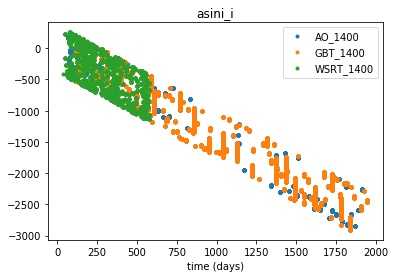

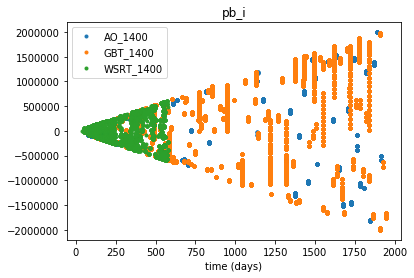

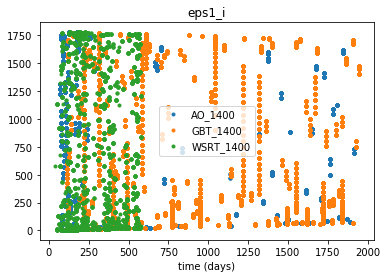

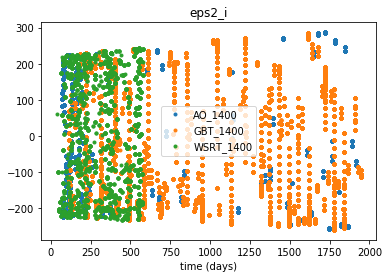

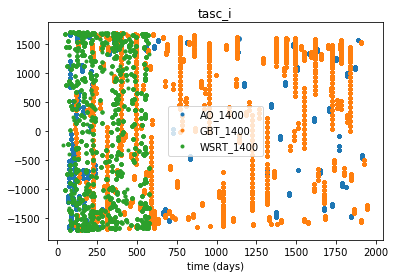

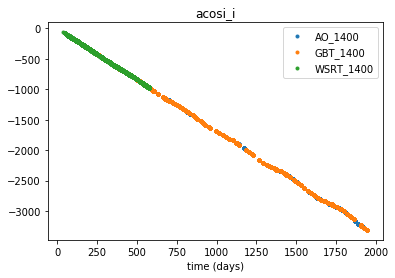

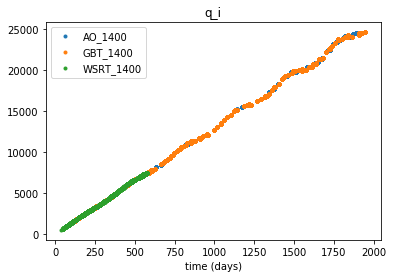

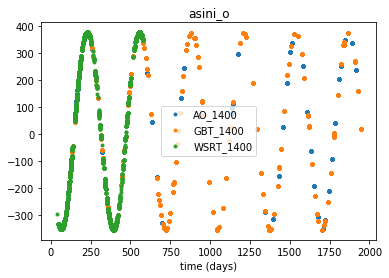

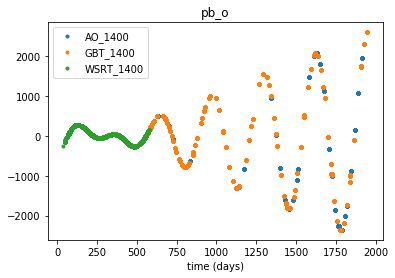

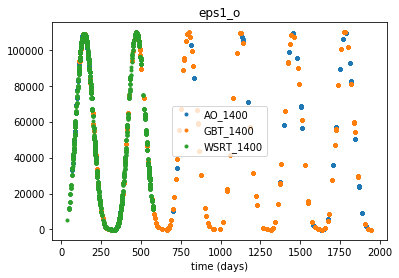

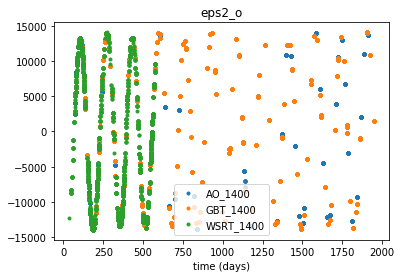

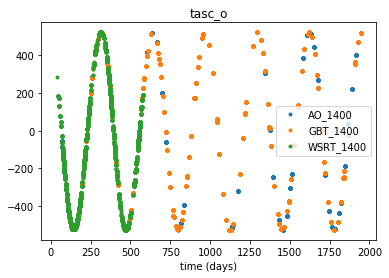

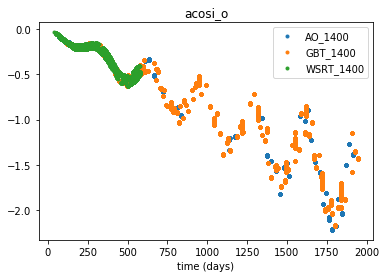

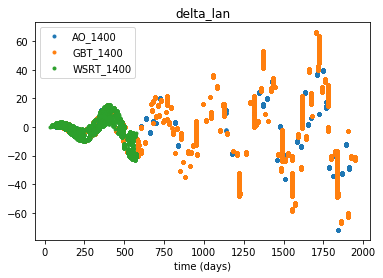

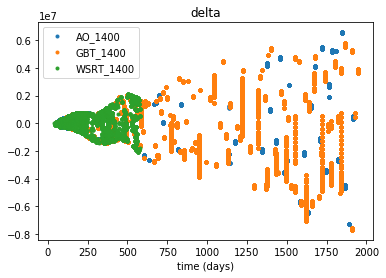

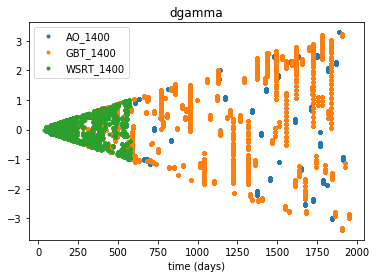

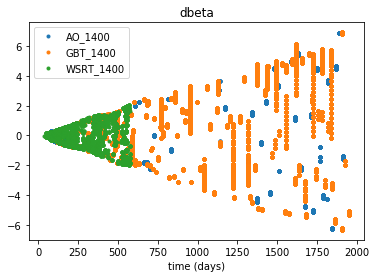

In [72]:
for p in F.parameters:
    plt.figure()
    plt.title(p)
    threebody.tplot(F, derivs[p])
    plt.legend()


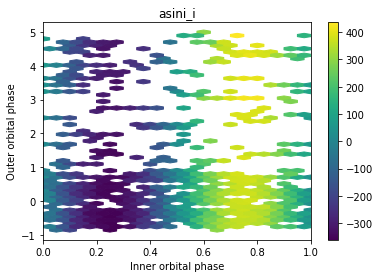

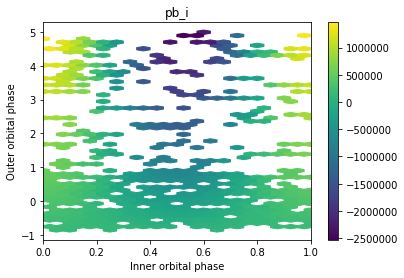

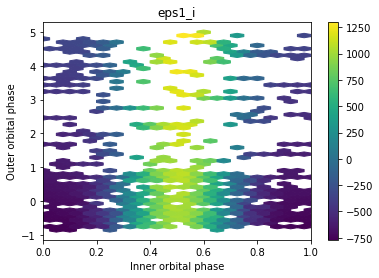

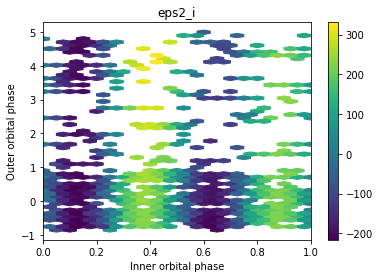

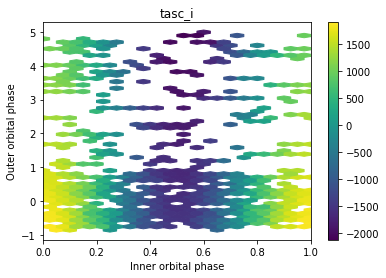

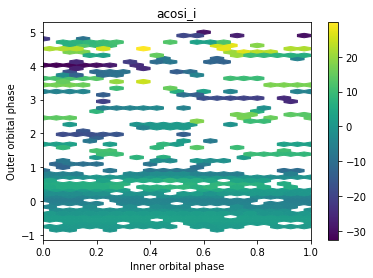

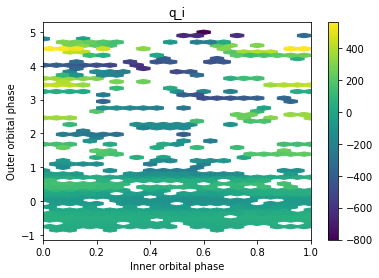

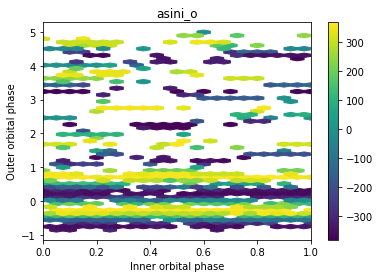

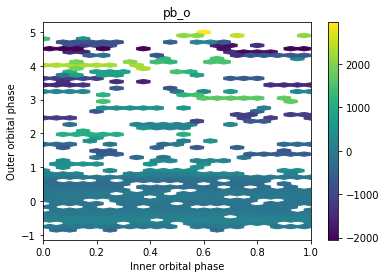

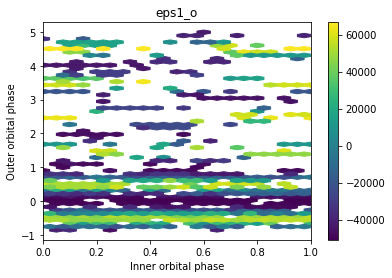

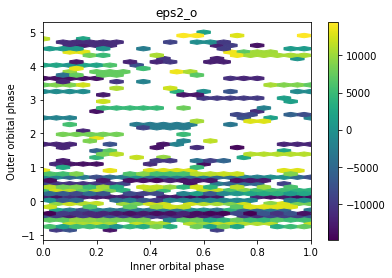

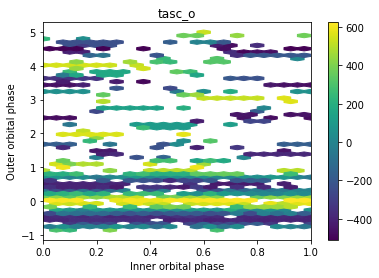

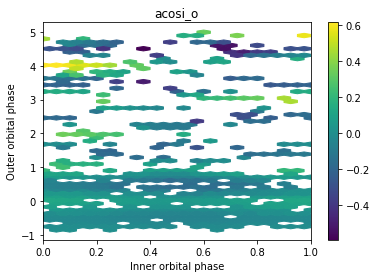

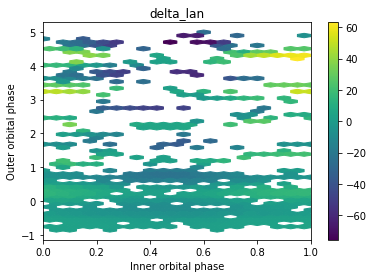

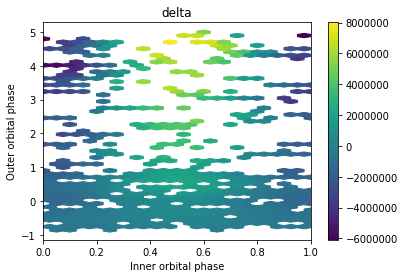

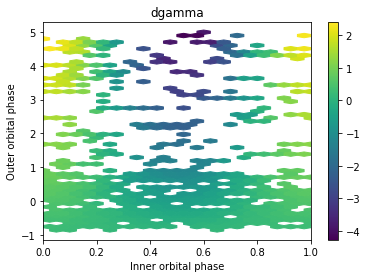

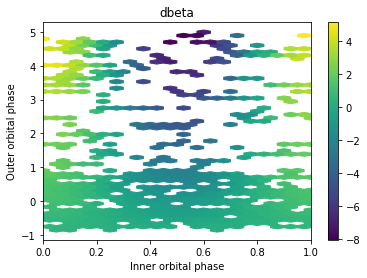

In [73]:
for p in F.parameters:
    plt.figure()
    plt.title(p)
    threebody.hexplot(F.best_parameters, F.mjds, d_clean[p],
                      gridsize=[20,30])
    plt.colorbar()